In [23]:
import sys

sys.path.insert(0, "..")
from src.data import make_dataset, data_tools
import numpy as np
import tifffile
from src.settings import EurosatSettings


# 1 Download data
This will take about 30 minutes
While waiting, read about the dataset we are using on their [github](https://github.com/phelber/eurosat)

In [24]:
settings = EurosatSettings()
data_dir = settings.data_dir
data_path = data_dir
# datapath = make_dataset.get_eurosat(data_dir)


Load all valid paths. The files are images in .tif format

In [25]:
valid_paths = data_dir / settings.valid_paths
all_paths, _ = data_tools.iter_valid_paths(valid_paths, formats=[".tif"])
all_paths = [*all_paths]


You can load the files with `tifffile.imread("path/to/img.tif")`

In [26]:
loadtime = %timeit -o tifffile.imread(all_paths[1])
loadtime.average * 2 * 32 * 1000

1.18 ms ± 3.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


75.49750125714179

As you can see, loading a tifffile is pretty fast. I clock 1.24 ms per image. This means that you expect the loader to take at least 1.24 x 4 images x batchsize x 1000 milliseconds, which is around 160ms. 

If your dataloader would take much more time than that (e.g. 500 ms per batch) you are doing something inefficient in your code.

# 2 motivation: Siamese networks
<img src="https://929687.smushcdn.com/2633864/wp-content/uploads/2020/11/keras_siamese_networks_header.png?lossy=1&strip=1&webp=1" />

We will build a dataloader for a Siamese network.
This is a semi-unsupervised architecture. It:
- takes in *two* images instead of one
- every image is processed by the *same* model (e.g. a CNN)
- the output of the model is a vector. Your input is (batch, channels, width, height) and the output is (batch, dimensions). Think of the vectors as locations in a space. E.g. you can locate Utrecht with two dimenions: (52.0929, 5.1045) on the globe (latitude, longitude). This is the same idea, only here the vector has more than 2 dimensions.
- after this, you can compare the *distance* between the two vectors.
- The distance should be close if the images are the same, or far away if they are not.

# 3 Datastructure
We will not build a siamese network, just the dataloader.
This means we will need a dataloader that spits out:
(X1, X2, y)  instead of our usual (X, y).

The label y will be: 1 if the two images are from the same class, 0 otherwise.

The most naive approach would be something like is implemented [here](https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity): to get the same class, you just keep on loading images at random in a while loop untill you hit the same class by accident... 

I hope you can understand why this is a *horrible* idea in terms of efficiency!
And another reason to be very carefull to implement random code from the internet...

To spell out why: with 10 classes (or, even worse, 40 classes in the example link) you will pick every class with a chance $p=\frac{1}{10}$ (or $p=\frac{1}{40}$). So the chance you *dont* pick the same class is $(1-p)$. You would have to do about 6 random picks to get close to a 50% chance of picking the same class ($0.9^6=0.53$), and even up to 26 guesses with 40 classes ($0.975^{26}=0.51$). This is a horrible waste of resources. You will end up spending a big chunk of your time loading random images, and it scales absolutely horrific with more classes (try to calculate how often you need to guess with 100 classes, or 150...) So, can we do better?

We will use a different datastructure to do this in a proper way! No worries, I will help you along the way.


As a datastructure, we will need something where we easily can pull two images from the same class. To do this, we will make a `Dict[int, np.array]` where the numpy array is an array of paths.

We use the np.array instead of the list, in order to be able to quickly grab two random items from the array with an integer index.

A dummy example is below

In [27]:
dummy = {
    0: np.array(["path/to/a/01.jpg", "path/to/a/02.jpg"]),
    1: np.array(["path/to/b/03.jpg", "path/to/b/04.jpg"]),
    2: np.array(["path/to/c/05.jpg", "path/to/c/06.jpg", "path/to/c/07.jpg"]),
}

[len(v) for k, v in dummy.items()]


[2, 2, 3]

You see we have three classed (a, b and c), that are in the dictionary as class 0, 1, and 2, and every class has two or three images listed (to be exact with the last line of code: 2, 2, and 3).

In addition to this, we want our dataset to have a name_mapping that is a `Dict[str, int]` which maps from the names to an integer. In our case this will be

```python
name_mapping = {
    "a" : 0,
    "b" : 1,
    "c" : 2
}
```

If we need two images from class 2, we can create a random index [0, 2] and the code example below will give us two images (the 0th and the 2nd) that are from the same class.

In [28]:
classlabel = 2
idx = np.array([0, 2])
dummy[classlabel][idx]

array(['path/to/c/05.jpg', 'path/to/c/07.jpg'], dtype='<U16')

## Question 1
We want to implement `EuroSatDataset`, which inherits from `BaseDataset`.
### Implement `__len__`
in the example above, the lenght of the dataset is 2+2+3=7.
The lengths of the dataset is the count of all paths in all classes.

Implement the `__len__` method in the EuroSatDataset in data_tools.py so that it returns the correct lenght of the dataset.


## Question 2
### implement process_data

Finish `process_data`. You need to fill the dataset dict structure.
To do this, you need to map a key (which is an integer: the label mapped to an int).
In our example, the label "a" should be stored as key 0. Use `name_mapping` for that:

```python
name_mapping["a"]
```

will return the correct integer we can use as a key.

You also need to store the values: paths in an np.array. 
To do this, we will start with an empty np.array, and keep appending new paths to this array.
While that is not an ideal thing to do, we only need to do this once so it is acceptable.

The endresult of `process_data` should be, that the input `all_paths` is transformed into a Dict[int, np.array] dataset, just like the dummy example below.

```python
dummy = {
    0: np.array(["path/to/a/01.jpg", "path/to/a/02.jpg"]),
    1: np.array(["path/to/b/03.jpg", "path/to/b/04.jpg"]),
    2: np.array(["path/to/c/05.jpg", "path/to/c/06.jpg", "path/to/c/07.jpg"]),
}
```

In [29]:
classlabel = 2
idx = np.array([0, 2])
dummy[classlabel][idx]


array(['path/to/c/05.jpg', 'path/to/c/07.jpg'], dtype='<U16')

In [30]:
eurosat = data_tools.EuroSatDataset(paths=all_paths)


100%|██████████| 20495/20495 [00:00<00:00, 53186.37it/s]


You can run this test

In [31]:
dataset = eurosat.dataset
[len(v) for k, v in dataset.items()], eurosat.name_mapping, len(dataset)


([1499, 3000, 1499, 1499, 1499, 3000, 2500, 1499, 2500, 2000],
 {'Forest': 0,
  'SeaLake': 1,
  'Highway': 2,
  'Industrial': 3,
  'AnnualCrop': 4,
  'Residential': 5,
  'PermanentCrop': 6,
  'HerbaceousVegetation': 7,
  'River': 8,
  'Pasture': 9},
 10)

# Question 3
## implement batchloop

It is not straightforward to implement a mechanism that picks two random images from the same class, and two random images from different classes, and do so at speed.
I made an implementation to help you on the way.

My implementation is fast enough, but if you dont want to use it you can implement it in another way for yourself.

The endresult should be the same, however:
- fill a batch with 50% similar images from the same class with label 1 (x1, x2, 1) and 50% images with different classes with label 0 (x1, x2, 0)

My random_index() function returns five items. The first two are:
- equal (int): this is a random class key from which to pick similar images
- same (List[np.array]) : this is a list of indexes. You can use an index to get two images from the class 

A working example with the dummy data is like this:

In [32]:
equal = 2 # from class two
same = [np.array([0, 1]), np.array([0, 2])] # we can pick these two combos
idx = same[0] # we use the first one of the combos
x1, x2 = dummy[equal][idx] # and retrieve from class 2 the paths on index 0 and 1
x1, x2

('path/to/c/05.jpg', 'path/to/c/06.jpg')

As you can see, this selects images from class number 2 (`equal`)
The images selected are the 0th and 1th (`same[0]`).
The result is two paths, both in class "c" (which is the 2nd class).

The other 3 items random_index() returns are:
- i and j. Two different class keys 
- other. A list of tuples, every tuple contains two indexes, one from class i, one from class j 

In [33]:
i = 0 # the first class we will pick from
j = 2 # the second class we will pick from
other = [(0, 0), (0, 2), (1, 2)] # these are the possible path indeces

idx = other[0] # we take the first combo
x1, x2 = dummy[i][idx[0]], dummy[j][idx[1]] 
# and extract from class i the 0th path (idx[0]),
# and from class j also the 0th path (idx[1]))
x1, x2 # this gives us two paths, from different classes


('path/to/a/01.jpg', 'path/to/c/05.jpg')

As you can see, even though the two indexes in `other` are both 0, one of them is pulled from class i, the other from class j.
We end up with two different paths from class "a" and class "c".

Implement this mechanism in SiameseStreamer.batchloop()

## Tests
You can run these tests to see if everything works as expected

In [34]:
len(eurosat)

20495

In [35]:
streamer = data_tools.SiameseStreamer(
    dataset=eurosat,
    batchsize=32,
).stream()


In [41]:
%timeit x1, x2, y = next(streamer)

412 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


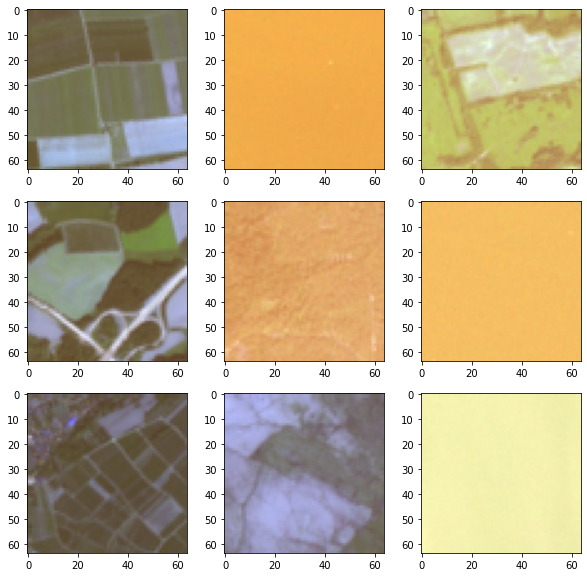

In [45]:
import matplotlib.pyplot as plt


def show_tif(img):
    img_ = img[..., [1, 2, 3]]
    x = img_.astype(np.int32)
    x = x / x.max()
    return x


fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()
for i in range(9):
    img1, img2, y = next(streamer)
    x = show_tif(img1[0])
    axs[i].imshow(x)
